In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import xarray as xr
import os

## Generate Input Data

In [2]:
t = np.arange(0, 120, 0.1)
P1, P2 = 2.326, 2.0 
wave1 = 0.1 * np.sin(2*np.pi*t/P1)
wave2 = 0.1 * np.sin(2*np.pi*t/P2)
eta = wave1 + wave2

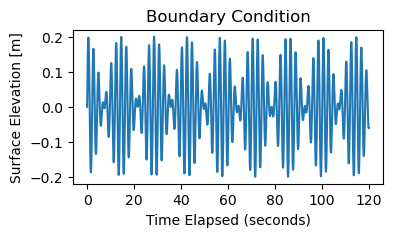

In [3]:
plt.figure(figsize=(4,2))
plt.title("Boundary Condition")
plt.xlabel("Time Elapsed (seconds)")
plt.ylabel("Surface Elevation [m]")
plt.plot(t, eta)
plt.show()

In [4]:
x = np.linspace(-63.0, 10, 1000)
beta = 1/43.5
h = x*beta

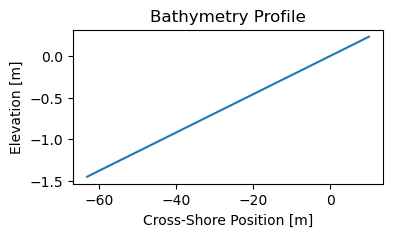

In [5]:
plt.figure(figsize=(4,2))
plt.title("Bathymetry Profile")
plt.xlabel("Cross-Shore Position [m]")
plt.ylabel("Elevation [m]")
plt.plot(x, h)
plt.show()

## Create SWASH Input

In [6]:
# Create SWASH directory and switch to that directory
def ensure_dir(path):
    dir = os.path.dirname(path)
    if not os.path.exists(dir):
        os.makedirs(dir)
ensure_dir('/home/cassandra/Willapa/SWASH1D-turb/')
os.chdir('/home/cassandra/Willapa/SWASH1D-turb/')

In [7]:
# For 2D SWASH, generate x and y grid, and create bathymetric profile (zz)
xp = x
yp = np.array([-1, 0, 1])
xx, yy = np.meshgrid(xp, yp)
zz = xx*beta

In [8]:
# How many grid cells in x,y
mxc = len(xp) - 1
myc = len(yp) -1

# Coordinates / Grid file
grid_data = {}
for i in range(mxc+1):
    grid_data.update({i:np.append(xx[:,i], yy[:,i])})
grid_2d_df = pd.DataFrame.from_dict(grid_data)
grid_2d_df.to_csv('coords.txt', sep=' ', header=False, index=False)

# Bathy
bot_2d_df = pd.DataFrame.from_dict({str(i):np.around(zz[:,i],5) for i in range(mxc+1)})
bot_2d_df.to_csv('bathy.txt', sep=' ', header=False, index=False)    

In [9]:
# Method for converting time (in seconds) to a format SWASH input likes
def format_time(t):
    hours = int(t/3600)
    minutes = int(t/60 % 60)
    seconds = int(t % 60)
    ms = int(1000*(t % 1))
    return str(hours).zfill(2) + str(minutes).zfill(2) + str(seconds).zfill(2) + '.' + str(ms).zfill(3)

# Time series file    
file_content = ""
for j in range(len(t)):
    file_content += format_time(t[j]) + ' ' + "{:.7f}".format(np.around(eta[j], 8)) + '\n'
with open('bc.txt', 'w') as file:
    file.write(file_content)

In [10]:
template = """
$*************** STARTUP *********************
$
PROJ 'default' '01'
MODE NONSTationary TWODimensional
$*************** COMPUTATIONAL GRID *********************
$
CGRID CURV {mxc} {myc}
READgrid COORdinates 1 'coords.txt' 1 0 0 FREE
VERT 10
$*************** BATHYMETRY *********************
$
INPgrid BOTtom CURV
READinp BOTtom -1 'bathy.txt' 1 0 FREE
SET depmin = 0.010
SET level = 0
$*************** BOUNDARY CONDITIONS *********************
$
BOUN SEGMent XY -63.0 -1 -63.0 1 BTYPE WEAKrefl CON SERIes 'bc.txt' 7
$*************** PHYSICS *********************
$
FRIC MANN 0.019
SET BACKVISC 1.e-4
$ BREAK 0.6 0.3
VISC VERT KEPS
$*************** NUMERICS *********************
$
NONHYDROSTATIC BOX 1. PRECONDITIONER ILU
DISCRET CORRDEP MUSCL 
DISCRET UPW UMOM MOM VERT FIR
DISCRET UPW UMOM MOM HOR MUSCL
DISCRET UPW WMOM VERT FIR
DISCRET UPW WMOM HOR MUSCL
TIMEI 0.4 0.8
$************ OUTPUT REQUESTS *************************  
$
BLOCK 'COMPGRID' NOHEAD 'output.mat' XP YP BOTL WATL VKSIK VETAK HK OUTPUT 000000.000 0.1 SEC
COMPUTE 000000.000 0.1 SEC {timestr}
STOP
"""

In [11]:
model_time = 60*2
hours, minutes, seconds = int(model_time/3600), int(model_time/60 - 60*int(model_time/3600)), model_time%60
timestr = "{hours:02d}{minutes:02d}{seconds:02d}.000".format(hours=hours, minutes=minutes, seconds=seconds)

ini_string = template.format(mxc=mxc, myc=myc, timestr=timestr, xmax=max(xp), ymax=max(yp))
input_file = open('INPUT', "w")
input_file.write(ini_string)
input_file.close()

## Export SWASH Matlab Output to netcdf

In [12]:
# load matlab output file
maf = '/home/cassandra/Willapa/SWASH1D-turb/output.mat'
m = scipy.io.loadmat(maf)

# Get x,y coordinates and bottom elevation
x = np.unique(m['Xp'])
y = np.unique(m['Yp'])
botlev = -1*m['Botlev']

# Read timestamps
t = []
for key_str in list(m.keys())[6:]:
    key_str_split = key_str.split('_')
    milliseconds = np.timedelta64( int(key_str_split[-1]),         'ms')
    seconds      = np.timedelta64( int(key_str_split[-2][-2:]),    's')
    minutes      = np.timedelta64( int(key_str_split[-2][-4:-2]),  'm')
    hours        = np.timedelta64( int(key_str_split[-2][-6:-4]),  'h')
    td = np.timedelta64(hours + minutes + seconds + milliseconds)
    t.append(td)
t = np.unique(t)
t = np.array(t).astype('timedelta64[ms]')

/home/cassandra/anaconda3/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Xp" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/home/cassandra/anaconda3/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Yp" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/home/cassandra/anaconda3/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Botlev" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [13]:
# Annoying method to format time BACK to SWASH matlab key format
def format_time(tm):
    t = np.around(tm.astype(int)/1000, 3) # in seconds, float data type, precision 3
    hours = int(t/3600)
    minutes = int(t/60 - hours*60)
    seconds = int(t - hours*3600 - minutes*60)
    ms = int(np.around(t*1000 - hours*3600*1000 - minutes*60*1000 - seconds*1000))
    return str(hours).zfill(2) + str(minutes).zfill(2) + str(seconds).zfill(2) + '_' + str(ms).zfill(3)
tfs = [format_time(tt) for tt in t]

In [14]:
# Layer index strings for SWASH matlab key format
n_layers = 10
ls = [str(n+1).zfill(2) for n in range(n_layers)]

In [15]:
# Get layered and non-layered quantities... doing it manually for Reasons
eta = np.array([m['Watlev_' + tf] for tf in tfs])
u = np.array([[m['Vksi_k' + l + '_' + tf] for tf in tfs] for l in ls])
v = np.array([[m['Veta_k' + l + '_' + tf] for tf in tfs] for l in ls])
ld = np.array([[m['hk' + l + '_' + tf] for tf in tfs] for l in ls])

Generate an xarray dataset and drop the y coordinate while I'm at it...

In [16]:
data_dict = {  'eta': (['t', 'x'],               eta[:, 1, :]),
                 'u': (['layer_n', 't', 'x'],      u[:, :, 1, :]),
   'layer_thickness': (['layer_n', 't', 'x'],     ld[:, :, 1, :]),
             'z_bed': (['x'],                 botlev[1, :])}
coords_dict = {'x':x, 't':t, 'layer_n':list(range(10))}
ds = xr.Dataset(data_dict, coords=coords_dict)

In [17]:
ds

<xarray.Dataset> Size: 101MB
Dimensions:          (t: 1201, x: 1000, layer_n: 10)
Coordinates:
  * x                (x) float32 4kB -63.0 -62.93 -62.85 ... 9.854 9.927 10.0
  * t                (t) timedelta64[ms] 10kB 00:00:00 ... 00:01:59.999000
  * layer_n          (layer_n) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    eta              (t, x) float32 5MB 0.0 0.0 0.0 0.0 ... 0.2364 0.2381 0.239
    u                (layer_n, t, x) float32 48MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    layer_thickness  (layer_n, t, x) float32 48MB 0.1448 0.1447 ... 0.000906
    z_bed            (x) float32 4kB -1.448 -1.447 -1.445 ... 0.2282 0.2299

In [18]:
ds.to_netcdf('/home/cassandra/Willapa/SWASH1D-turb/output.nc')

## Sanity Checks

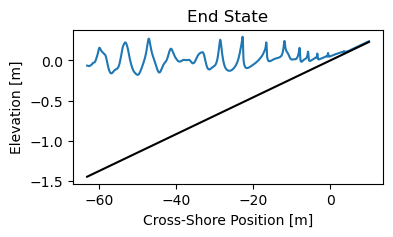

In [20]:
plt.figure(figsize=(4,2))
plt.title("End State")
plt.xlabel("Cross-Shore Position [m]")
plt.ylabel("Elevation [m]")
plt.plot(ds.x, ds.eta[-1,:])
plt.plot(ds.x, ds.z_bed, color='black')
plt.show()

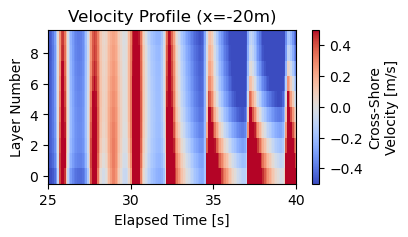

In [33]:
xi = np.argmin(np.abs(x + 20))

plt.figure(figsize=(4,2))
plt.title("Velocity Profile (x=-20m)")
plt.xlabel("Elapsed Time [s]")
plt.ylabel("Layer Number")
m = plt.pcolormesh(ds.t.astype(float)/1000, ds.layer_n, ds.u[:,:,xi], 
                   cmap='coolwarm', vmin=-0.5, vmax=0.5)
cb = plt.colorbar(m)
cb.ax.set_ylabel("Cross-Shore\nVelocity [m/s]")
plt.xlim(25, 40)
plt.show()

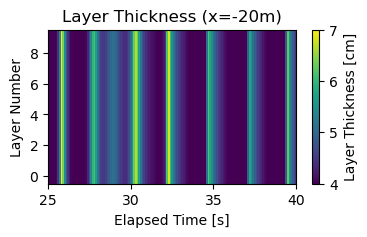

In [39]:
plt.figure(figsize=(4,2))
plt.title("Layer Thickness (x=-20m)")
plt.xlabel("Elapsed Time [s]")
plt.ylabel("Layer Number")
m = plt.pcolormesh(ds.t.astype(float)/1000, ds.layer_n, 100*ds.layer_thickness[:,:,xi], vmin=4, vmax=7)
cb = plt.colorbar(m)
cb.ax.set_ylabel("Layer Thickness [cm]")
plt.xlim(25, 40)
plt.show()

Notably, layer thickness is layer-independent (they are always equipartitioned)

## Converting Layer Thickness / Number to Elevation

In [49]:
# Layer z level
# Is this right?
layer_bins = np.arange(0, 11, 1)
layer_width = ds.layer_thickness.values[0,:,:]
layer_bin_z = ds.eta.values[np.newaxis,:,:] - layer_width[np.newaxis,:,:] * layer_bins[:,np.newaxis,np.newaxis]

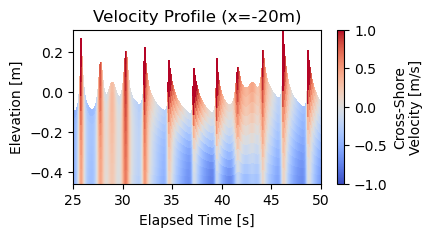

In [53]:
plt.figure(figsize=(4,2))
plt.title("Velocity Profile (x=-20m)")
plt.xlabel("Elapsed Time [s]")
plt.ylabel("Elevation [m]")

# Nice how this "just works" with a 1d/2d/3d x/y/z input like this
m = plt.pcolormesh(ds.t.astype(float)/1000, layer_bin_z[:,:,xi], ds.u[:,1:,xi], 
                   cmap='coolwarm', vmin=-1.0, vmax=1.0)

cb = plt.colorbar(m)
cb.ax.set_ylabel("Cross-Shore\nVelocity [m/s]")
plt.xlim(25, 50)
plt.show()